In [195]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Loading the dataset
data = pd.read_csv('data/bank-additional-full-preprocessed.csv')
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

__Fitting Random Forest__

In [196]:
from sklearn.model_selection import train_test_split

# Get Target data
y = data['y']

# Load X variable in to the dataframe
X = data.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [199]:
# Creating param grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to test
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [200]:
# Checking for the best parameters
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [201]:
# building the model based on optimal parameters
orf_model = RandomForestClassifier(
    **random_search.best_params_
)

# fitting the model
orf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200)

In [202]:
# Checking for accuracy

print(f"Train Accuracy - : {orf_model.score(X_train, y_train)}")
print(f"Test Accuracy - : {orf_model.score(X_test, y_test)}")

Train Accuracy - : 0.9133918351774132
Test Accuracy - : 0.9007040543821316


In [203]:
# Storing the predictions
rf_predictions = orf_model.predict(X_test)

__Fitting Neural Network__

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a model class that inherits nn module
class Model(nn.Module):
    def __init__(self,in_features=19,h1=35,h2=31,h3=32,out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.out = nn.Linear(h3,out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x


In [205]:
# pick a manual seed for randomization
torch.manual_seed(42)

# create instance of model
model = Model()

In [206]:
from sklearn.preprocessing import MinMaxScaler

# Normalizing Numerical Columns

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

numerical_columns = [
    'age',
    'campaign',
    'pdays',
    'previous',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'
]

# Normalize the columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

print(data)

            age  job  marital  education  default  housing  loan  contact  \
0      0.481481    3        1          0        0        0     0        1   
1      0.493827    7        1          3        1        0     0        1   
2      0.246914    7        1          3        0        2     0        1   
3      0.283951    0        1          1        0        0     0        1   
4      0.481481    7        1          3        0        0     2        1   
...         ...  ...      ...        ...      ...      ...   ...      ...   
41183  0.691358    5        1          5        0        2     0        0   
41184  0.358025    1        1          5        0        0     0        0   
41185  0.481481    5        1          6        0        2     0        0   
41186  0.333333    9        1          5        0        0     0        0   
41187  0.703704    5        1          5        0        2     0        0   

       month  day_of_week  campaign  pdays  previous  poutcome  emp.var.rat

In [207]:
# Train test Split

y = data['y']
X = data.drop(columns=['y'])

# Convert to numpy arrays
X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [208]:
# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y features to float tensors
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [209]:
# Set the criterion to measure the error
criterion = nn.CrossEntropyLoss()

# Choose Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [210]:
# Train model

# Determining Epochs
epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)

    # Ensure y_train is the correct type for classification
    y_train = y_train.long()

    # measure the loss
    loss = criterion(y_pred, y_train)

    # track loss
    losses.append(loss.detach().numpy())

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Text(0.5, 0, 'epoch')

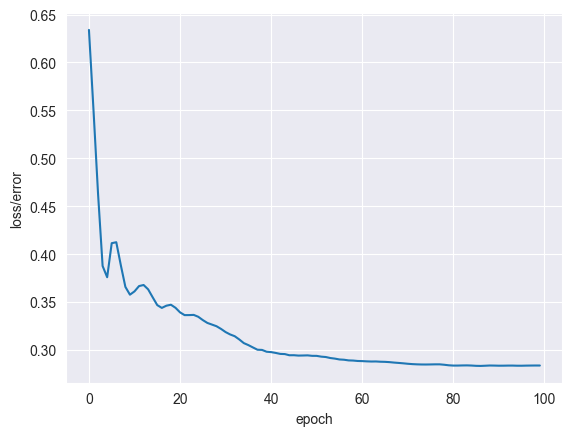

In [211]:
import matplotlib.pyplot as plt

# Visualizing error
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("epoch")

In [212]:
# Predictions for Neural Network
with torch.no_grad():
    nn_outputs = model(X_test)
    nn_predictions = torch.argmax(nn_outputs, dim=1).numpy()

In [214]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation Metrics
models = {'Random Forest': rf_predictions, 'Neural Network': nn_predictions}

for model_name, predictions in models.items():
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, predictions):.2f}")
    print(f"Precision: {precision_score(y_test, predictions):.2f}")
    print(f"Recall: {recall_score(y_test, predictions):.2f}")
    print(f"F1 Score: {f1_score(y_test, predictions):.2f}")



Random Forest Metrics:
Accuracy: 0.90
Precision: 0.65
Recall: 0.25
F1 Score: 0.36

Neural Network Metrics:
Accuracy: 0.90
Precision: 0.72
Recall: 0.18
F1 Score: 0.29
